<a target="_blank" href="https://colab.research.google.com/github/tom-mayr/market-basket-analysis/blob/main/final_code.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# AMD Market-Basket Analysis

## Preprocessing

### Data Download

First we set our Kaggle credentials and use the Kaggle-API to get the relevant dataset.

In [1]:
# Importing os module and setting credentials
import os
os.environ['KAGGLE_USERNAME'] = "xxxxx"
os.environ['KAGGLE_KEY'] = "xxxxx"

# installing the Kaggle-API and downloading and unzipping the dataset
!pip install kaggle
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -f job_skills.csv --force
!unzip -o job_skills.csv.zip

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 93% 182M/197M [00:01<00:00, 129MB/s]
100% 197M/197M [00:01<00:00, 119MB/s]
Archive:  job_skills.csv.zip
  inflating: job_skills.csv          


### Preparing the Data

Now that we have the data we perform some preprocessing procedures to ensure our data is clean, consistent and suitable for our algorithms.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a Spark session
spark = SparkSession.builder.appName("JobSkills").getOrCreate()

# Load the dataset as a Spark DataFrame
df = spark.read.csv('job_skills.csv', header=True).select('job_skills')

# Show the initial Spark DataFrame
# df.show()

# Replace NaN with an empty string in the 'job_skills' column
df = df.withColumn('job_skills', F.coalesce(F.col('job_skills'), F.lit('')))

# Split the 'job_skills' string into a list of skills
df = df.withColumn('job_skills', F.split(F.col('job_skills'), ','))

# Remove leading/trailing whitespaces from each skill in the 'job_skills' array
df = df.withColumn('job_skills', F.expr("transform(job_skills, x -> trim(x))"))

# Apply transformation to convert each element to lowercase
df = df.withColumn('job_skills', F.expr("transform(job_skills, x -> lower(x))"))

# (Optional for performance) Reduce the size of the dataset for testing purposes
# Fraction of data we want to work with
frac = 0.1
df_reduced = df.sample(fraction=frac, seed=42)
# Alternative with explicit size
# df_reduced = df.limit(1000)

# What is the number of rows of the reduced dataset
n_rows = df_reduced.count()
print(f'Reduced dataset has {n_rows} rows.')

# Remove duplicates in each 'job_skills' array by converting it to a set and back to a list
df_reduced = df_reduced.withColumn('job_skills', F.array_distinct(F.col('job_skills')))

# Show the final transformed DataFrame
df_reduced.show()

# Prepare the transactions RDD
transactions = df_reduced.select('job_skills').rdd.map(lambda row: row['job_skills'])

Reduced dataset has 128989 rows.
+--------------------+
|          job_skills|
+--------------------+
|[veterinary recep...|
|[biomedical engin...|
|[program manageme...|
|[customer service...|
|[programmable log...|
|[administrative s...|
|[management accre...|
|[executive assist...|
|[restaurant manag...|
|[teaching, art, c...|
|[cinemark, custom...|
|[maintenance, aut...|
|[retail managemen...|
|[applied behavior...|
|[supply chain, lo...|
|[cleaning, house ...|
|[hvac, heating an...|
|[medical assistan...|
|[patient check in...|
|[a&p mechanic, a&...|
+--------------------+
only showing top 20 rows



## Apriori Algorithm

To find frequent itemsets we implement the Apriori algorithm from scratch.

### Implementation

In [3]:
from itertools import combinations

# Implement the Apriori algorithm as a function
def apriori(transactions, min_support_frac):
    """
    Implements the Apriori algorithm to find frequent itemsets in a dataset.

    Parameters:
    - transactions: RDD of transactions, where each transaction is a list of items.
    - min_support_frac: Minimum support threshold as a fraction of the total number of transactions.

    Returns:
    - final_frequent_itemsets: List of tuples containing frequent itemsets and their counts.
    """
    # Initialize SparkContext
    sc = transactions.context

    # Extract all unique skills from the transactions
    unique_skills = transactions.flatMap(lambda basket: basket).distinct().collect()

    # Create mappings
    skill_to_int = {skill: idx for idx, skill in enumerate(unique_skills)}
    int_to_skill = {idx: skill for skill, idx in skill_to_int.items()}

    # Broadcast mappings to worker nodes
    skill_to_int_broadcast = sc.broadcast(skill_to_int)
    int_to_skill_broadcast = sc.broadcast(int_to_skill)

    # Encode transactions using the skill_to_int mapping
    def encode_transaction(basket):
        return [skill_to_int_broadcast.value[skill] for skill in basket if skill in skill_to_int_broadcast.value]

    transactions = transactions.map(encode_transaction)

    # Get the total number of transactions
    num_transactions = transactions.count()

    # Calculate minimum support as an integer count
    min_support = max(1, round(min_support_frac * num_transactions))  # Ensure at least support of 1

    # Generate frequent itemsets of size 1
    # Flatten all items and count their frequencies
    item_counts = transactions.flatMap(lambda basket: basket)\
                              .map(lambda item: (frozenset([item]), 1))\
                              .reduceByKey(lambda a, b: a + b)

    # Filter items that meet the minimum support
    frequent_items = item_counts.filter(lambda x: x[1] >= min_support)

    # Collect frequent items
    frequent_items_list = frequent_items.map(lambda x: x[0]).collect()
    frequent_items_set = set(frequent_items_list)

    # Filter transactions to only include frequent items
    def filter_frequent(basket):
        return [item for item in basket if frozenset([item]) in frequent_items_set]

    filtered_transactions = transactions.map(filter_frequent)

    # Initialize variables for iterative process
    k = 2
    current_frequent_itemsets = frequent_items  # Includes counts
    final_frequent_itemsets = frequent_items.collect()  # Now includes counts

    while True:
        # Collect current frequent itemsets to driver
        prev_frequent_itemsets = current_frequent_itemsets.map(lambda x: x[0]).collect()
        prev_frequent_itemsets_set = set(prev_frequent_itemsets)

        # Generate candidate itemsets of size k
        candidates = []
        for i in range(len(prev_frequent_itemsets)):
            for j in range(i+1, len(prev_frequent_itemsets)):
                union_set = prev_frequent_itemsets[i].union(prev_frequent_itemsets[j])
                if len(union_set) == k:
                    candidates.append(union_set)
        candidates = set(candidates)

        # Prune candidates with infrequent subsets
        def has_infrequent_subset(candidate):
            subsets = combinations(candidate, k - 1)
            for subset in subsets:
                if frozenset(subset) not in prev_frequent_itemsets_set:
                    return False
            return True

        candidates = [candidate for candidate in candidates if has_infrequent_subset(candidate)]

        if not candidates:
            break

        # Broadcast the candidates for efficient lookup
        candidates_broadcast = sc.broadcast(candidates)

        # Count the frequency of each candidate
        def count_candidates(basket):
            basket_set = set(basket)
            counts = []
            for candidate in candidates_broadcast.value:
                if candidate.issubset(basket_set):
                    counts.append((candidate, 1))
            return counts

        candidate_counts = filtered_transactions.flatMap(count_candidates)\
                                               .reduceByKey(lambda a, b: a + b)

        # Unpersist the broadcast variable to free up memory
        candidates_broadcast.unpersist()

        # Filter candidates that meet the minimum support
        current_frequent_itemsets = candidate_counts.filter(lambda x: x[1] >= min_support)

        # Collect frequent itemsets
        current_frequent_itemsets_list = current_frequent_itemsets.collect()

        # Break if no frequent itemsets are found
        if not current_frequent_itemsets_list:
            break

        final_frequent_itemsets.extend(current_frequent_itemsets_list)

        # Prepare for next iteration
        k += 1

    # Decode itemsets
    final_frequent_itemsets = [([int_to_skill_broadcast.value[item] for item in itemset], count)
                               for itemset, count in final_frequent_itemsets]

    # Convert frozensets to lists for readability
    #final_frequent_itemsets = [(list(itemset), count) for itemset, count in final_frequent_itemsets]

    return final_frequent_itemsets


### Analysis

In [4]:
# Call the apriori function
final_frequent_itemsets = apriori(transactions, min_support_frac = 0.01)

# Display the final frequent itemsets with their frequencies
print("Frequent Itemsets with Frequencies:")
for itemset, count in final_frequent_itemsets:
    print(f"{itemset}: {count}")

Frequent Itemsets with Frequencies:
['time management']: 14047
['microsoft office']: 5883
['problemsolving']: 12628
["driver's license"]: 3218
['equal opportunity employer']: 2693
['prioritization']: 2580
['leadership']: 18311
['marketing']: 2935
['professional development']: 2314
['patient education']: 2569
['cpr']: 2414
['physical stamina']: 2267
['cash handling']: 3201
['strategic planning']: 1565
['budgeting']: 4404
['forecasting']: 1532
['sales']: 9252
['negotiation']: 3128
['team collaboration']: 1490
['initiative']: 2280
['analytical skills']: 6044
['quality control']: 3751
['manufacturing']: 1607
['leadership skills']: 2284
['word']: 1666
['retail']: 2179
['civil engineering']: 1582
['construction management']: 1505
['paid holidays']: 1499
['employee assistance program']: 1570
['401(k)']: 1582
['accounting']: 3468
['technical writing']: 1383
['construction']: 1440
['team work']: 1749
["master's degree"]: 1691
['customer service']: 27603
['problem solving']: 14529
['innovation']

### Visualising Frequent Itemsets

In order to make some sense we visualise our results with some bar plots. Each plot shows the Top-5 frequent itemsets of a specific size.

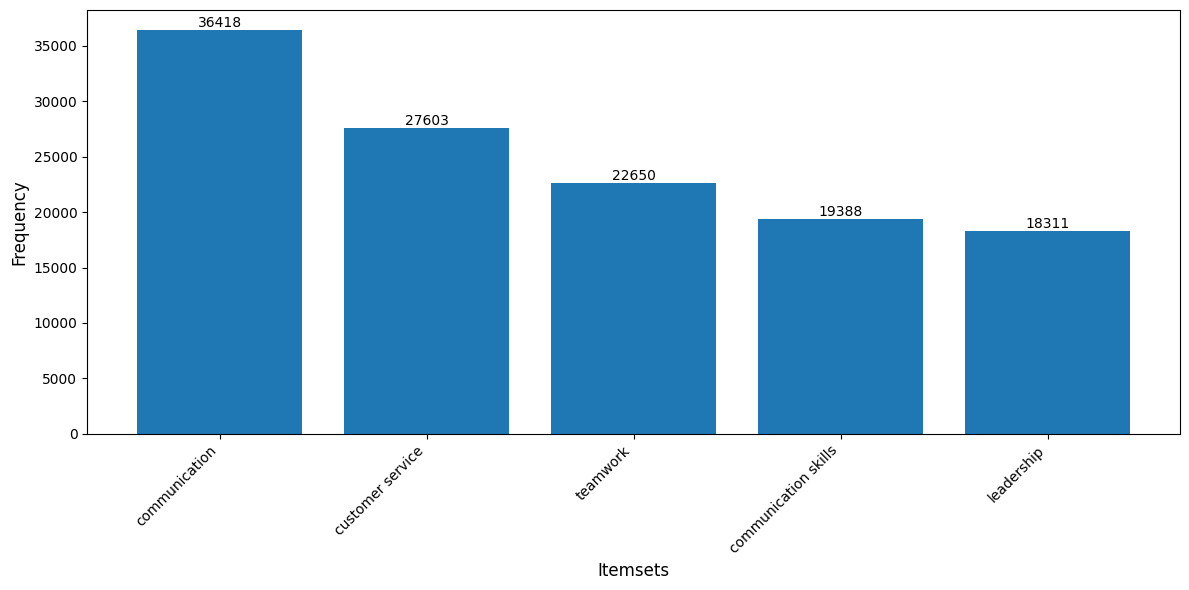

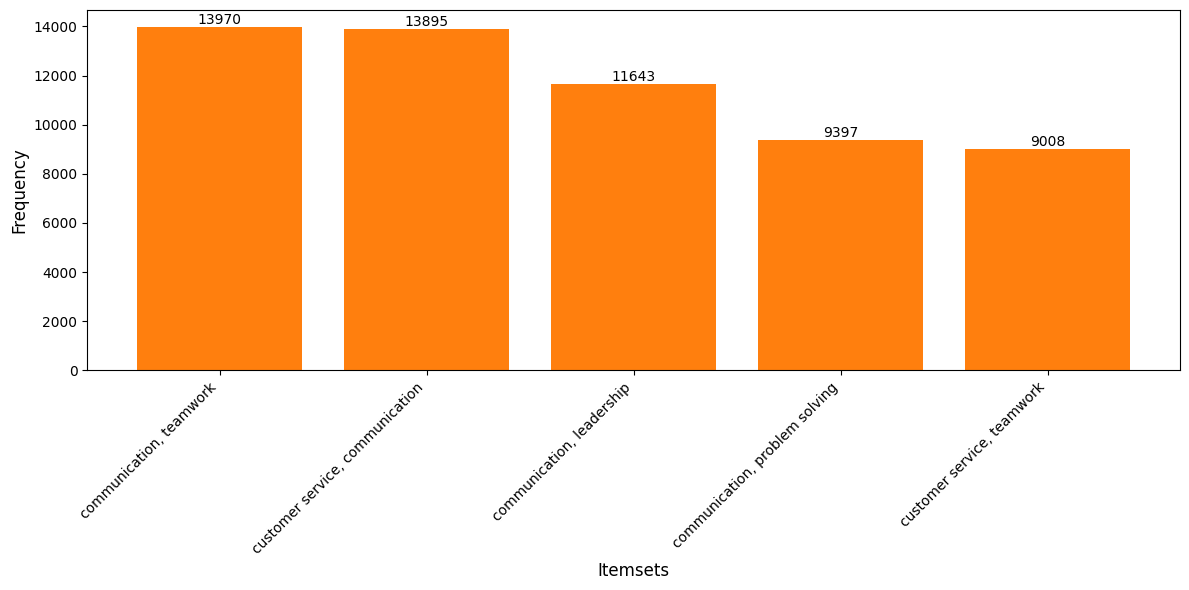

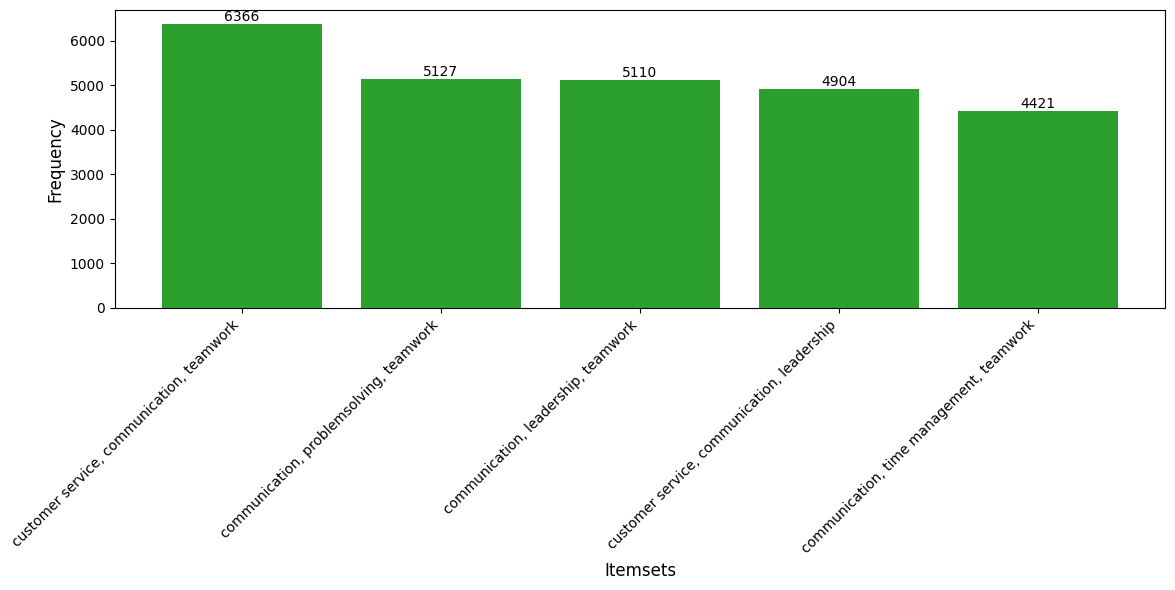

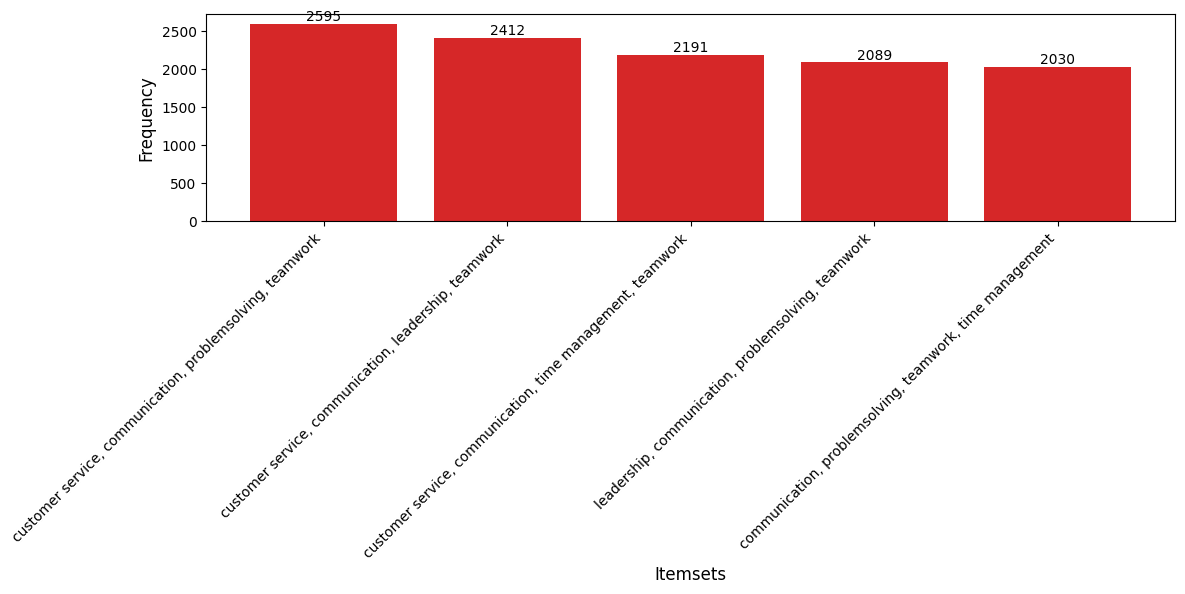

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

# Organize frequent itemsets by their size
itemsets_by_size = defaultdict(list)
for itemset, count in final_frequent_itemsets:
    size = len(itemset)
    itemsets_by_size[size].append((itemset, count))

# For each size, sort the itemsets by frequency in descending order
for size in itemsets_by_size:
    itemsets_by_size[size] = sorted(itemsets_by_size[size], key=lambda x: x[1], reverse=True)

# Different color for each plot
n_sizes = len(itemsets_by_size.keys())
colors = list(mcolors.TABLEAU_COLORS.keys())
colors[:n_sizes]

# Visualize the most frequent itemsets
for size, color in zip(sorted(itemsets_by_size.keys()), colors):
    itemsets_counts = itemsets_by_size[size]
    # Limit to top N itemsets for visualization
    top_n = 5
    top_itemsets_counts = itemsets_counts[:top_n]

    # Prepare data for plotting
    labels = [', '.join(itemset) for itemset, count in top_itemsets_counts]
    counts = [count for itemset, count in top_itemsets_counts]

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, counts, color=color)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Itemsets', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    # plt.title(f'Top {top_n} Frequent Itemsets of Size {size}', fontsize=14)
    plt.tight_layout()

    # Annotate bars with counts
    for bar, count in zip(bars, counts):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, count, ha='center', va='bottom', fontsize=10)

    plt.show()


## FP-Growth

In [6]:
# FP Growth
from pyspark.ml.fpm import FPGrowth

# Apply FP-Growth
fp_growth = FPGrowth(itemsCol="job_skills", minSupport=0.01, minConfidence=0.7)
model = fp_growth.fit(df_reduced)

# Display frequent itemsets
frequent_itemsets = model.freqItemsets
frequent_itemsets.sort('freq', ascending=False).show()

# Display association rules
association_rules = model.associationRules
association_rules.sort('lift', ascending=False).show()

+--------------------+-----+
|               items| freq|
+--------------------+-----+
|     [communication]|36418|
|  [customer service]|27603|
|          [teamwork]|22650|
|[communication sk...|19388|
|        [leadership]|18311|
|   [problem solving]|14529|
|   [time management]|14047|
|[teamwork, commun...|13970|
|[customer service...|13895|
|[attention to det...|13125|
|    [problemsolving]|12628|
|[project management]|11992|
|[leadership, comm...|11643|
|      [patient care]| 9899|
|[interpersonal sk...| 9858|
|[problem solving,...| 9397|
|             [sales]| 9252|
|[teamwork, custom...| 9008|
|[problemsolving, ...| 8885|
|           [nursing]| 8740|
+--------------------+-----+
only showing top 20 rows

+--------------------+--------------------+------------------+------------------+--------------------+
|          antecedent|          consequent|        confidence|              lift|             support|
+--------------------+--------------------+------------------+----------

In [7]:
# Define the target skill
target_skill = "excel"

# Count of target skill in the data set
print(df_reduced.filter(F.array_contains(F.col('job_skills'), target_skill)).count())

frequent_itemsets = model.freqItemsets.filter(f"array_contains(items, '{target_skill}')").sort('freq', ascending=False)
frequent_itemsets.show()

# Get association rules where the antecedent contains the target skill
association_rules = model.associationRules.filter(f"array_contains(antecedent, '{target_skill}')")
association_rules.show(truncate=False)

4093
+--------------------+----+
|               items|freq|
+--------------------+----+
|             [excel]|4093|
|       [word, excel]|1538|
|[excel, communica...|1338|
+--------------------+----+

+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+



In [8]:
# Stop Spark session
spark.stop()